# Lesson 6. Spatial Queries

In spatial analysis, our goal is not just to make nice maps,
but to actually run analyses that leverage the explicitly spatial
nature of our data. The process of doing this is known as 
**spatial analysis**.

To construct spatial analyses, we string together series of spatial
operations in such a way that the end result answers our question of interest.
There are many such spatial operations. These are known as **spatial queries**.


- 6.0 Load and prep some data
- 6.1 Measurement Queries
- 6.2 Relationship Queries
- **Exercise**: Spatial Relationship Query
- 6.3 Proximity Analysis
- **Exercise**: Proximity Analysis

-------------------

We will start by reviewing the most
fundamental set, which we'll refer to as **spatial queries**.
These can be divided into:

- <u>Measurement queries</u>
    - What is feature A's **length**?
    - What is feature A's **area**?
    - What is feature A's **perimeter**?
    - What is feature A's **distance** from feature B?
    - etc.
- <u>Relationship queries</u>
    - Is feature A **within** feature B?
    - Does feature A **intersect** with feature B?
    - Does feature A **cross** feature B?
    - etc.
    
We'll work through examples of each of those types of queries.

Then we'll see an example of a very common spatial analysis that 
is a conceptual amalgam of those two types: **proximity analysis**.

In [1]:
import pandas as pd
import geopandas as gpd

import matplotlib # base python plotting library
import matplotlib.pyplot as plt # submodule of matplotlib

# get the solution hider
from solution_hider import hide_solution

# To display plots, maps, charts etc in the notebook
%matplotlib inline  

# 6.0 Load and prep some data

Let's read in our census tracts data again.

<AxesSubplot:>

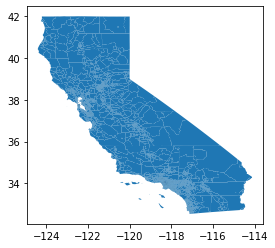

In [2]:
census_tracts = gpd.read_file("zip://notebook_data/census/Tracts/cb_2013_06_tract_500k.zip")
census_tracts.plot()

In [3]:
census_tracts.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,06,001,400300,1400000US06001400300,06001400300,4003,CT,1105329,0,"POLYGON ((-122.26416 37.84000, -122.26186 37.8..."
1,06,001,400900,1400000US06001400900,06001400900,4009,CT,420877,0,"POLYGON ((-122.28558 37.83978, -122.28319 37.8..."
2,06,001,402200,1400000US06001402200,06001402200,4022,CT,712082,0,"POLYGON ((-122.30403 37.80739, -122.30239 37.8..."
3,06,001,402800,1400000US06001402800,06001402800,4028,CT,398311,0,"POLYGON ((-122.27598 37.80622, -122.27335 37.8..."
4,06,001,404800,1400000US06001404800,06001404800,4048,CT,628405,0,"POLYGON ((-122.21825 37.80086, -122.21582 37.8..."


Then we'll grab just the Alameda Country tracts.

<AxesSubplot:>

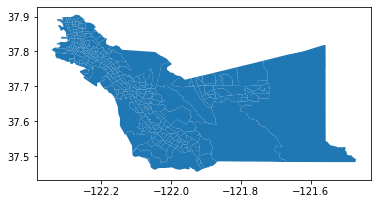

In [4]:
census_tracts_ac = census_tracts.loc[census_tracts['COUNTYFP']=='001'].reset_index(drop=True)
census_tracts_ac.plot()

# 6.1 Measurement Queries

We'll start off with some simple measurement queries.

For example, here's how we can get the areas of each of our census tracts.

In [5]:
census_tracts_ac.area

0      0.000113
1      0.000045
2      0.000071
3      0.000041
4      0.000063
         ...   
356    0.000098
357    0.002275
358    0.000033
359    0.000139
360    0.000316
Length: 361, dtype: float64

Okay! 

We got... 

numbers!

...?

<div style="display:inline-block;vertical-align:top;">
    <img src="http://www.pngall.com/wp-content/uploads/2016/03/Light-Bulb-Free-PNG-Image.png" width="30" align=left > 
</div>  
<div style="display:inline-block;">

#### Questions
</div>

1. What do those numbers mean?
1. What are our units?
1. And if we're not sure, how might be find out?

Let's take a look at our CRS.

In [6]:
census_tracts_ac.crs

{'init': 'epsg:4269'}

Ah-hah! We're working in an unprojected CRS, with units of decimal degrees.

**When doing spatial analysis, we will almost always want to work in a projected CRS
that has natural distance units, such as meters!**

Time to project!

(As previously, we'll use UTM Zone 10N with a NAD83 data.
This is a good choice for our region of interest.)

In [7]:
census_tracts_ac_utm10 = census_tracts_ac.to_crs( "epsg:26910")

/usr/lib/python3.8/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [8]:
census_tracts_ac_utm10.crs

'epsg:26910'

Now let's try our area calculation again.

In [9]:
census_tracts_ac_utm10.area

0      1.105797e+06
1      4.355184e+05
2      6.930523e+05
3      4.003615e+05
4      6.183936e+05
           ...     
356    9.653980e+05
357    2.230584e+07
358    3.197167e+05
359    1.355161e+06
360    3.087534e+06
Length: 361, dtype: float64

That looks much more reasonable!

<div style="display:inline-block;vertical-align:top;">
    <img src="http://www.pngall.com/wp-content/uploads/2016/03/Light-Bulb-Free-PNG-Image.png" width="30" align=left > 
</div>  
<div style="display:inline-block;">

#### Question
</div>

What are our units now?


You may have noticed that our census tracts already have an area column in them.

Let's do a sanity check on our results.

In [10]:
# calculate the area for the 0th feature
census_tracts_ac_utm10.area[0]

1105796.6056939538

In [11]:
# get the area for the 0th feature according to its 'ALAND' attribute
census_tracts['ALAND'][0]

1105329

In [12]:
# check equivalence of the calculated areas and the 'ALAND' column
census_tracts_ac_utm10['ALAND'].values == census_tracts_ac_utm10.area

0      False
1      False
2      False
3      False
4      False
       ...  
356    False
357    False
358    False
359    False
360    False
Length: 361, dtype: bool

<div style="display:inline-block;vertical-align:top;">
    <img src="http://www.pngall.com/wp-content/uploads/2016/03/Light-Bulb-Free-PNG-Image.png" width="30" align=left > 
</div>  
<div style="display:inline-block;">

#### Question
</div>

What explains this disagreement? Are the calculated areas incorrect?


# TODO: <font color='red'> WHY SUMMING THE AREAS HERE? </font>

We can also sum the area for Alameda county by adding `.sum()` to the end of our area calculation.

In [13]:
census_tracts_ac_utm10.area.sum()

1948917581.1122959

We can actually look up how large Alameda County is to check our work.The county is 739 miles<sup>2</sup>, which is around 1,914,001,213 meters<sup>2</sup>. I'd say we're pretty close!

As it turns out, we can similarly use another attribute
to get the features' lengths.

**NOTE**: In this case, given we're
dealing with polygons, this is equivalent to getting the features' perimeters.

In [14]:
census_tracts_ac_utm10.length

0       5357.060239
1       2756.937555
2       5395.895162
3       2681.974829
4       3710.388859
           ...     
356     4331.600289
357    32004.773556
358     2353.624225
359     4718.701537
360     8176.643793
Length: 361, dtype: float64

# 6.2 Relationship Queries


[Spatial relationship queries](https://en.wikipedia.org/wiki/Spatial_relation) consider how two geometries or sets of geometries relate to one another in space. 

<img src="https://upload.wikimedia.org/wikipedia/commons/5/55/TopologicSpatialRelarions2.png" height="300px"></img>


Here is a list of the most commonly used GeoPandas methods to test spatial relationships.

- [within](http://geopandas.org/reference.html?highlight=distance#geopandas.GeoSeries.within)
- [contains](http://geopandas.org/reference.html?highlight=distance#geopandas.GeoSeries.contains) (the inverse of `within`)
- [intersects](http://geopandas.org/reference.html?highlight=distance#geopandas.GeoSeries.intersects)

<br>
There several other GeoPandas spatial relationship predicates but they are more complex to properly employ. For example the following two operations only work with geometries that are completely aligned.

- [touches](http://geopandas.org/reference.html?highlight=distance#geopandas.GeoSeries.touches)
- [equals](http://geopandas.org/reference.html?highlight=distance#geopandas.GeoSeries.equals)


All of these methods takes the form:

    Geoseries.<predicate>(geometry)
    
For example:

    Geoseries.contains(geometry)

--------------------------------

Let's load a new dataset to demonstrate these queries.

This is a dataset containing all the protected areas (parks and the like) in California.

In [15]:
pas = gpd.read_file('./notebook_data/protected_areas/CPAD_2020a_Units.shp')

Does this need to be reprojected too?

In [16]:
pas.crs

{'init': 'epsg:3310'}

Yes it does!

Let's reproject it.

In [17]:
pas_utm10 = pas.to_crs("epsg:26910")

/usr/lib/python3.8/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


One common use for spatial queries is for spatial subsetting of data.

In our case, lets use **intersects** to
find all of the parks that have land in Alameda County.

In [18]:
census_tracts_ac_utm10.geometry.squeeze()

0      POLYGON ((564744.993 4188317.651, 564946.532 4...
1      POLYGON ((562861.148 4188278.725, 563070.421 4...
2      POLYGON ((561264.509 4184672.770, 561409.095 4...
3      POLYGON ((563734.437 4184562.158, 563961.943 4...
4      POLYGON ((568821.460 4184008.066, 569030.992 4...
                             ...                        
356    POLYGON ((591097.402 4154398.989, 591400.070 4...
357    POLYGON ((578528.935 4151915.982, 578732.686 4...
358    POLYGON ((563141.438 4184274.978, 563293.747 4...
359    POLYGON ((572695.844 4175004.761, 572801.274 4...
360    POLYGON ((581072.943 4169465.752, 581136.259 4...
Name: geometry, Length: 361, dtype: geometry

In [19]:
pas_in_ac = pas_utm10.intersects(census_tracts_ac_utm10.geometry.unary_union)

If we scroll the resulting GeoDataFrame to the right we'll see that 
the `COUNTY` column of our resulting subset gives us a good sanity check on our results.

In [20]:
pas_utm10[pas_in_ac].head()

,ACCESS_TYP,UNIT_ID,UNIT_NAME,SUID_NMA,AGNCY_ID,AGNCY_NAME,AGNCY_LEV,AGNCY_TYP,AGNCY_WEB,LAYER,...,MNG_AG_LEV,MNG_AG_TYP,PARK_URL,COUNTY,ACRES,LABEL_NAME,YR_EST,DES_TP,GAP_STS,geometry
63,Open Access,185,Augustin Bernal Park,8732,1257,"Pleasanton, City of",City,City Agency,http://www.cityofpleasantonca.gov/,City,...,City,City Agency,http://www.cityofpleasantonca.gov/services/rec...,Alameda,217.388,Augustin Bernal Park,0.0,Local Park,4,"POLYGON ((595746.574 4165882.573, 595740.013 4..."
145,Open Access,366,San Antonio Park,24832,1228,"Oakland, City of",City,City Agency,http://www2.oaklandnet.com/Government/o/opr/in...,City,...,City,City Agency,None,Alameda,10.619,San Antonio Park,0.0,Local Park,4,"POLYGON ((566704.422 4182789.292, 566827.750 4..."
217,Open Access,586,Quarry Lakes Regional Recreation Area,30594,2032,East Bay Regional Park District,Special District,Recreation/Parks District,http://www.ebparks.org/,Special District,...,Special District,Recreation/Parks District,None,Alameda,254.616,Quarry Lakes Reg. Rec. Area,2001.0,Local Recreation Area,4,"MULTIPOLYGON (((588060.979 4158338.499, 587843..."
393,Open Access,1438,Tennis & Community Park,26243,1257,"Pleasanton, City of",City,City Agency,http://www.cityofpleasantonca.gov/,City,...,City,City Agency,None,Alameda,15.595,Tennis & Community Park,0.0,Local Park,4,"POLYGON ((596761.389 4170334.335, 597109.868 4..."
408,Open Access,48353,Sean Diamond Park,32917,1090,"Dublin, City of",City,City Agency,http://www.ci.dublin.ca.us/index.aspx?nid=1458,City,...,City,City Agency,https://www.dublin.ca.gov/Facilities/Facility/...,Alameda,4.986,Sean Diamond Park,2018.0,Local Park,4,"POLYGON ((601693.284 4175288.100, 601695.836 4..."


So does this overlay plot!

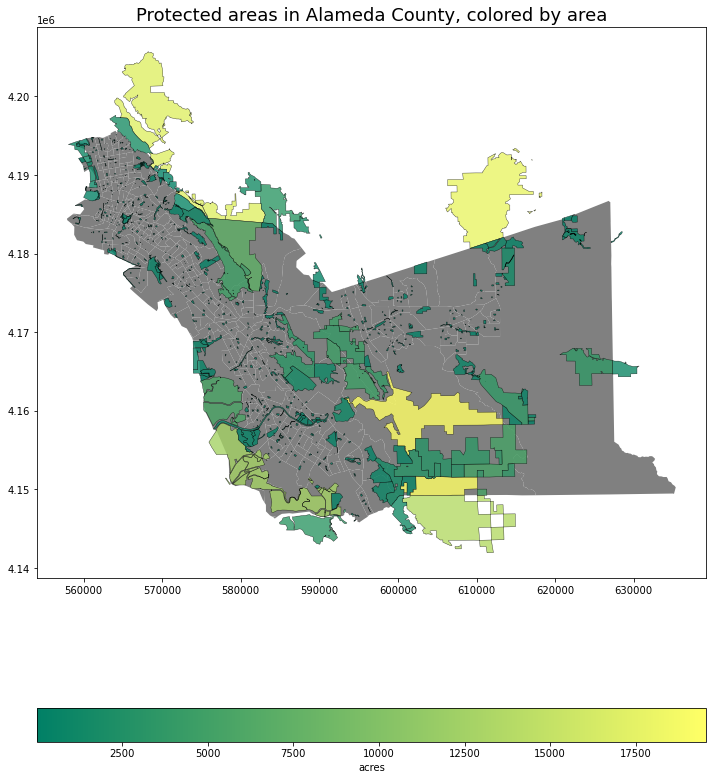

In [21]:
ax = census_tracts_ac_utm10.plot(color='gray', figsize=[12,16])
pas_utm10[pas_in_ac].plot(ax=ax, column='ACRES', cmap='summer', legend=True,
                          edgecolor='black', linewidth=0.4, alpha=0.8,
                          legend_kwds={'label': "acres",
                                       'orientation': "horizontal"})
ax.set_title('Protected areas in Alameda County, colored by area', size=18);

In [22]:
# color by county?

# Exercise: Spatial Relationship Query

Let's use a spatial relationship query to create a new dataset containing Berkeley schools!

Run the next two cells to load datasets containing Berkeley's city boundary and Alameda County's
schools and to reproject them to EPSG: 26910.

Then in the following cell, write your own code to:
1. subset the schools for only those `within` Berkeley
2. plot the Berkeley boundary and then the schools as an overlay map

Your resulting map should look something like the map we provide below.

To see the solution, click the button below.

In [23]:
# load the Berkeley boundary
berkeley = gpd.read_file("notebook_data/berkeley/BerkeleyCityLimits.shp")

# transform to EPSG:26910
berkeley_utm10 = berkeley.to_crs("epsg:26910")

# display
berkeley_utm10.head()

/usr/lib/python3.8/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,CNTY_FIPS,geometry
0,001,"POLYGON ((564127.982 4195462.653, 564144.101 4..."


In [24]:
# load the Alameda County schools CSV
schools_df = pd.read_csv('notebook_data/alco_schools.csv')

# coerce it to a GeoDataFrame
schools_gdf = gpd.GeoDataFrame(schools_df, 
                               geometry=gpd.points_from_xy(schools_df.X, schools_df.Y))
# define its unprojected (EPSG:4326) CRS
schools_gdf.crs = "epsg:4326"

# transform to EPSG:26910
schools_gdf_utm10 = schools_gdf.to_crs( "epsg:26910")

# display
schools_df.head()

,X,Y,Site,Address,City,State,Type,API,Org,geometry
0,-122.238761,37.744764,Amelia Earhart Elementary,400 Packet Landing Rd,Alameda,CA,ES,933,Public,POINT (-122.23876 37.74476)
1,-122.251856,37.738999,Bay Farm Elementary,200 Aughinbaugh Way,Alameda,CA,ES,932,Public,POINT (-122.25186 37.73900)
2,-122.258915,37.762058,Donald D. Lum Elementary,1801 Sandcreek Way,Alameda,CA,ES,853,Public,POINT (-122.25892 37.76206)
3,-122.234841,37.765250,Edison Elementary,2700 Buena Vista Ave,Alameda,CA,ES,927,Public,POINT (-122.23484 37.76525)
4,-122.238078,37.753964,Frank Otis Elementary,3010 Fillmore St,Alameda,CA,ES,894,Public,POINT (-122.23808 37.75396)


In [25]:
# YOUR CODE HERE:






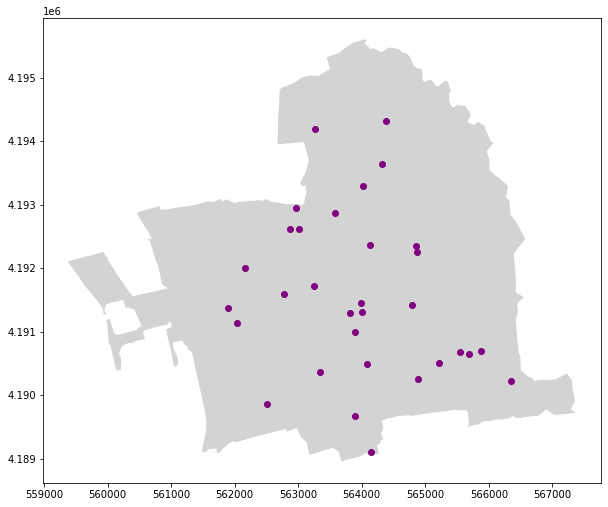

In [26]:
# SOLUTION:

# get the boolean Series indicating which schools are in Berkeley
schools_in_berkeley = schools_gdf_utm10.within(berkeley_utm10.geometry.squeeze())

# use that series to subset the schools for only those that are in Berkeley
berkeley_schools = schools_gdf_utm10[schools_in_berkeley]

# create a fig with one Axes object
fig, ax = plt.subplots(figsize=(10,10))
# plot the Berkeley border on those Axes
berkeley_utm10.plot(color='lightgrey', ax=ax)
# add the Berkeley schools to those Axes
berkeley_schools.plot(color='purple',ax=ax)

hide_solution()

# 6.3 Proximity Analysis

Now that we've seen the basic idea of spatial measurement and relationship queries,
let's take a look at a common analysis that combines those concepts: **promximity analysis**.

Proximity analysis seeks to identify all features in a focal feature set
that are within some maximum distance of features in a reference feature set.

A common workflow for this analysis is:

1. Buffer (i.e. add a margin around) the reference dataset, out to the maximum distance.
1. Run a spatial relationship query to find all focal features that intersect (or are within) the buffer.

---------------------------------

Let's read in our bike boulevard data again.

Then we'll find out which of our Berkeley schools are within a block's distance (200 m) of the boulevards.

<AxesSubplot:>

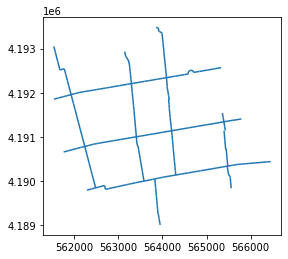

In [27]:
bike_blvds = gpd.read_file('notebook_data/transportation/BerkeleyBikeBlvds.geojson')
bike_blvds.plot()

Of course, we need to reproject the boulevards to our projected CRS.

In [28]:
bike_blvds_utm10 = bike_blvds.to_crs( "epsg:26910")

/usr/lib/python3.8/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Now we can create our 200 meter bike boulevard buffers.

In [29]:
bike_blvds_buf = bike_blvds_utm10.buffer(distance=200)

Now let's overlay everything.

<AxesSubplot:>

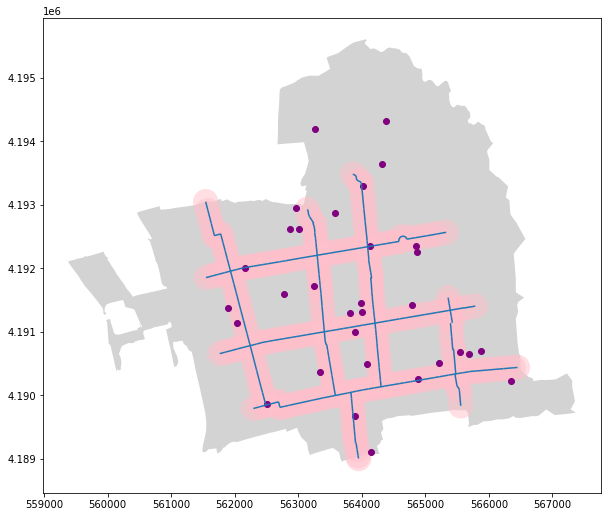

In [30]:
fig, ax = plt.subplots(figsize=(10,10))
berkeley_utm10.plot(color='lightgrey', ax=ax)
bike_blvds_buf.plot(color='pink', ax=ax, alpha=0.5)
bike_blvds_utm10.plot(ax=ax)
berkeley_schools.plot(color='purple',ax=ax)

Great! Looks like we're all ready to run our intersection to complete the proximity analysis.


**NOTE**: In order to subset with our buffers we need to call the `unary_union` attribute of the buffer object.
This gives us a single unified polygon, rather than a series of multipolygons representing buffers around each of the points in our multilines.

In [31]:
schools_near_blvds = berkeley_schools.within(bike_blvds_buf.unary_union)
blvd_schools = berkeley_schools[schools_near_blvds]

Now let's overlay again, to see if the schools we subsetted make sense.

<AxesSubplot:>

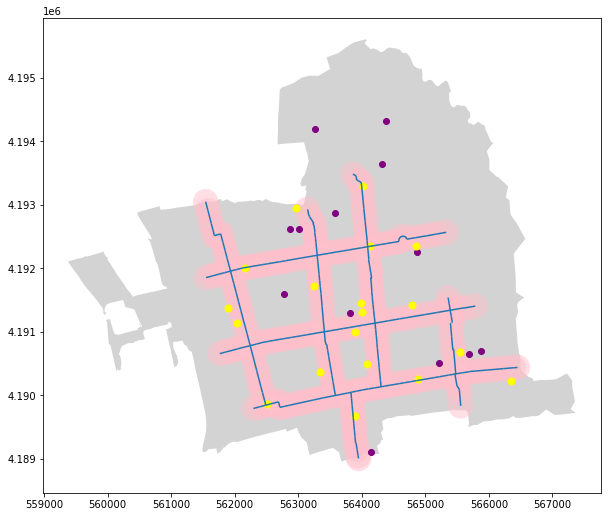

In [32]:
fig, ax = plt.subplots(figsize=(10,10))
berkeley_utm10.plot(color='lightgrey', ax=ax)
bike_blvds_buf.plot(color='pink', ax=ax, alpha=0.5)
bike_blvds_utm10.plot(ax=ax)
berkeley_schools.plot(color='purple',ax=ax)
blvd_schools.plot(color='yellow', markersize=50, ax=ax)

# TODO <font color='red'> CONSIDER WHETHER TO KEEP OR MOVE THIS AFTER DECIDING ABOUT DISTANCE STUFF </font>

In [33]:
def min_distance(point, lines):
    return lines.distance(point).min()

schools_gdf_utm10[schools_within_berkeley].geometry.apply(min_distance, args=(bike_blvds_utm10,))

NameError: name 'schools_within_berkeley' is not defined

# Exercise: Proximity Analysis

Now it's your turn to try out a proximity analysis!

Run the next cell to load our BART-system data, reproject it to EPSG: 26910, and subset it to Berkeley.

Then in the following cell, write your own code to find all schools within walking distance (1 km) of a BART station.

As a reminder, let's break this into steps:
1. buffer your Berkeley BART stations to 1 km (**HINT**: remember your units!)
2. use the schools' `within` attribute to check whether or not they're within the buffers (**HINT**: don't forget the `unary_union`!)
3. subset the Berkeley schools using the object returned by your spatial relationship query

4. as always, plot your results for a good visual check!

Your resulting plot should look something like the plot we provide below.

To see the solution, click the button below.

In [34]:
# load the BART stations from CSV
bart_stations = pd.read_csv('notebook_data/transportation/bart.csv')
# coerce to a GeoDataFrame
bart_stations_gdf = gpd.GeoDataFrame(bart_stations, 
                               geometry=gpd.points_from_xy(bart_stations.lon, bart_stations.lat))
# define its unprojected (EPSG:4326) CRS
bart_stations_gdf.crs = "epsg:4326"
# transform to UTM Zone 10 N (EPSG:26910)
bart_stations_gdf_utm10 = bart_stations_gdf.to_crs( "epsg:26910")
# subset to Berkeley
berkeley_bart = bart_stations_gdf_utm10[bart_stations_gdf_utm10.within(berkeley_utm10.unary_union)]

In [36]:
# YOUR CODE HERE:







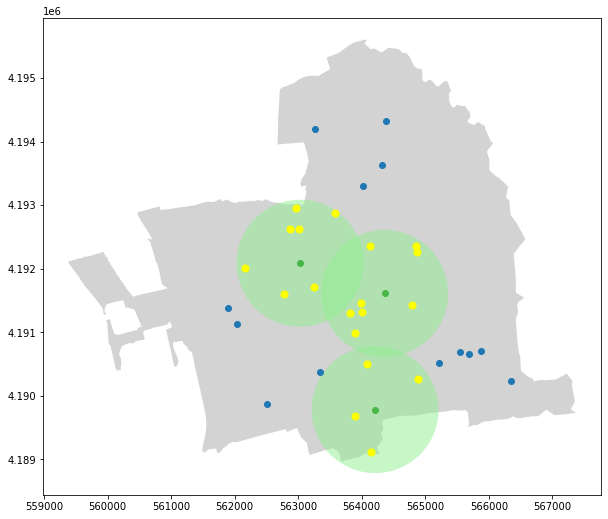

In [37]:
# buffer the BART stations to 1 km
bart_buf = berkeley_bart.buffer(distance=1000)
# check whether or not each school is within a buffer
schools_near_bart = berkeley_schools.within(bart_buf.unary_union)
# subset the schools using the boolean Series you just produced
bart_schools = berkeley_schools[schools_near_bart]

# create a fig with one Axes object
fig, ax = plt.subplots(figsize=(10,10))
# plot the Berkeley boundary (for reference)
berkeley_utm10.plot(color='lightgrey', ax=ax)
# plot the BART stations (for reference)
berkeley_bart.plot(color='green', ax=ax)
# add the BART buffers (for check)
bart_buf.plot(color='lightgreen', ax=ax, alpha=0.5)
# add all Berkeley schools (for reference)
berkeley_schools.plot(ax=ax)
# add the schools near BART (for check)
bart_schools.plot(color='yellow', markersize=50, ax=ax)

hide_solution()

---
<div style="display:inline-block;vertical-align:middle;">
<a href="https://dlab.berkeley.edu/" target="_blank"><img src ="../assets/images/dlab_logo.png" width="75" align="left">
</a>
</div>

<div style="display:inline-block;vertical-align:middle;">
    <div style="font-size:larger">&nbsp;D-Lab @ University of California - Berkeley</div>
    <div>&nbsp;Team Geo<div>
</div>
        


